<a href="https://colab.research.google.com/github/DhrubaAdhikary/ERA_V2/blob/master/S7/ERA1_S7_step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

## Loading Models

In [11]:
!pip install torchsummary
!git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
!mv ERA_V2/S7/*.py .
!rm -rf ERA_V2

## Step 2
### Target
1. Add image augmentation w random rotation and random affine to improve the model performance.


In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [14]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model

In [16]:
from model import *
Net = Model_2

## Model Params

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

## Training and Testing

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.23146791756153107 Batch_id=468 Accuracy=92.58: 100%|██████████| 469/469 [00:28<00:00, 16.22it/s]



Test set: Average loss: 0.0795, Accuracy: 9744/10000 (97.44%)

EPOCH: 1


Loss=0.06827087700366974 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]



Test set: Average loss: 0.0567, Accuracy: 9812/10000 (98.12%)

EPOCH: 2


Loss=0.11687814444303513 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0537, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.010653153993189335 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]



Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.050932627171278 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]



Test set: Average loss: 0.0342, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.04564465954899788 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]



Test set: Average loss: 0.0281, Accuracy: 9909/10000 (99.09%)

EPOCH: 6


Loss=0.03776680678129196 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]



Test set: Average loss: 0.0350, Accuracy: 9891/10000 (98.91%)

EPOCH: 7


Loss=0.1399477869272232 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]



Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.05935560166835785 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.022508779540657997 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 10


Loss=0.10073598474264145 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.0273, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.018570130690932274 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]



Test set: Average loss: 0.0298, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.03980061039328575 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0299, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.06267932057380676 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:22<00:00, 21.04it/s]



Test set: Average loss: 0.0313, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.01813485287129879 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:22<00:00, 20.91it/s]



Test set: Average loss: 0.0303, Accuracy: 9899/10000 (98.99%)



Text(0.5, 1.0, 'Test Accuracy')

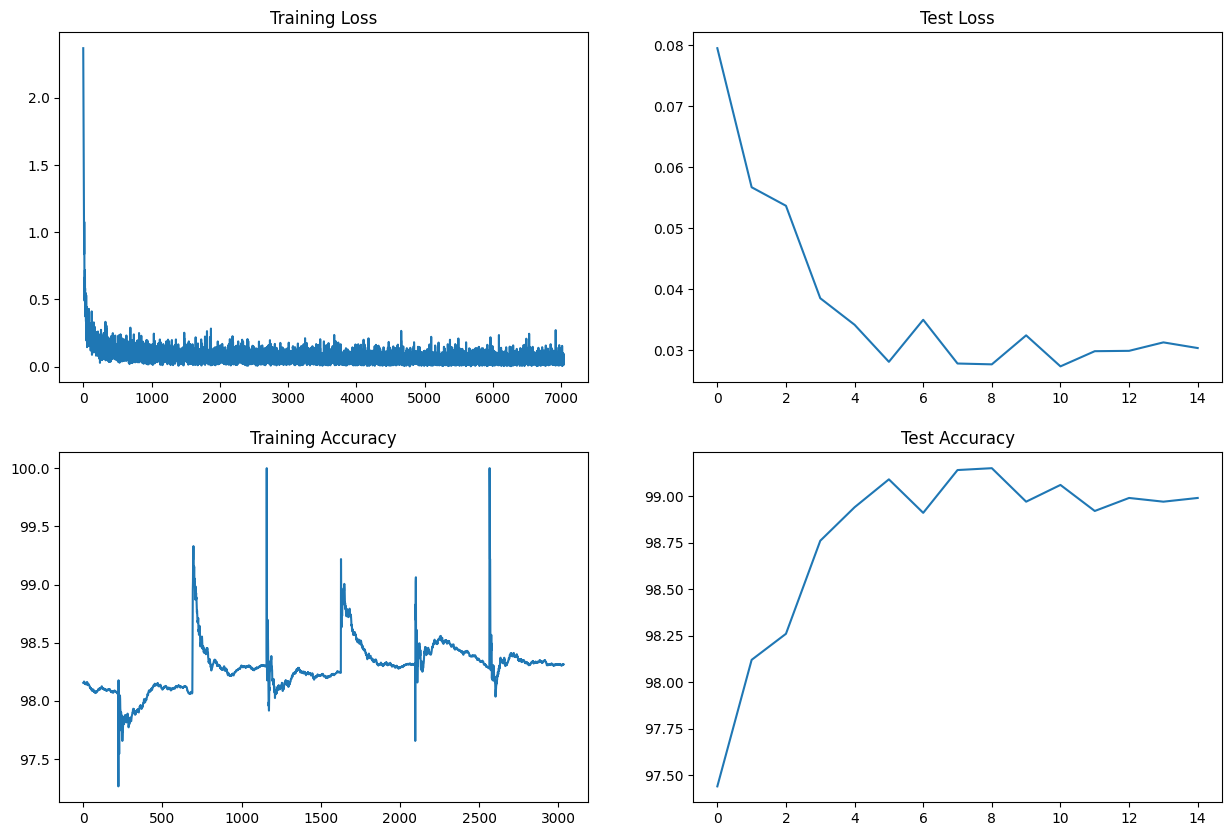

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")